In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
import os
import glob
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from keras.preprocessing import image

Using TensorFlow backend.


# Set Up MURA Dataset

In [2]:
data_dir = "..\\MURA-v1.1"

train_images_path = pd.read_csv(os.path.join(data_dir, 'train_image_paths.csv'),names=["Train Dataset"])
train_labels = pd.read_csv(os.path.join(data_dir, 'train_labeled_studies.csv'),names=["Train Labeled Studies", "label"])

validation_images_path = pd.read_csv(os.path.join(data_dir, 'valid_image_paths.csv'),names=["Validation Dataset"])
validation_labels = pd.read_csv(os.path.join(data_dir, 'valid_labeled_studies.csv'),names=["Validation Labeled Studies", "label"])

In [3]:
train_images_path = train_images_path.sort_values(by=['Train Dataset'])
train_labels = train_labels.sort_values(by=['Train Labeled Studies'])

validation_images_path = validation_images_path.sort_values(by=['Validation Dataset'])
validation_labels = validation_labels.sort_values(by=['Validation Labeled Studies'])

In [4]:
train_labels['Body Part'] = train_labels['Train Labeled Studies'].apply(lambda x: str(x.split('/')[2])[3:])
train_labels['Study Type'] = train_labels['Train Labeled Studies'].apply(lambda x: str(x.split('/')[4])[:6])

In [5]:
validation_labels['Body Part'] = validation_labels['Validation Labeled Studies'].apply(lambda x: str(x.split('/')[2])[3:])
validation_labels['Study Type'] = validation_labels['Validation Labeled Studies'].apply(lambda x: str(x.split('/')[4])[:6])

## Plot Data Statistics

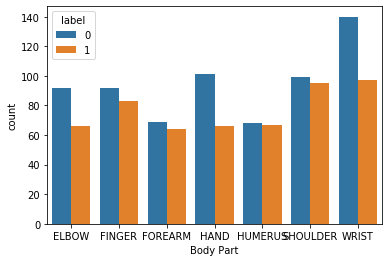

In [6]:
sns.countplot(data=validation_labels, x='Body Part', hue='label')

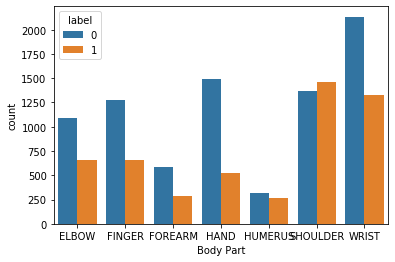

In [7]:
sns.countplot(data=train_labels, x='Body Part', hue='label')

## Read In Training and Validation Data

In [8]:
def get_image_array(image_dir):

    data_path = os.path.join(image_dir,'*g')
    files = glob.glob(data_path)
    data = []
    i=0
    for f1 in files:
        i=i+1
        img = cv2.imread(f1)
        data.append(img)
           
    return data

In [9]:
def load_data(data_dir, limit=None, body_part=None, dataset_type="train"):
    assert (body_part is None) or (type(body_part) == str)
    assert (limit is None) or ((type(limit) == int) and limit >= 0)
    
    train_X, train_y = [], []
    counter = 0
    
    if dataset_type == "train":
        file_path = data_dir + "//train_image_paths.csv"
    elif dataset_type == "validation":
        file_path = data_dir + "//valid_image_paths.csv"
    
    with open(file_path) as csv_file:
        data = pd.read_csv(csv_file, header=None)
        shuffled_data = data.sample(frac=1)
        
        for index, row in shuffled_data.iterrows():

            # Limit the number of read data examples.
            if limit and counter >= limit: break
            
            # Retrieve data specific to a given body part only.
            if body_part is not None and not body_part.upper() in row[0]: continue
                
            image_path = "..//" + row[0]
            img = image.load_img(image_path, target_size = (224, 224))
            img = image.img_to_array(img)
            img = np.expand_dims(img, axis = 0)
            #img = img.reshape((1,) + img.shape)

            train_X.append(img)
            train_y.append(label_image(row[0]))

            counter = counter + 1
            
    return np.asarray(train_X), np.asarray(train_y)

In [10]:
def label_image(img_path):
    return 1 if "positive" in img_path else 0

In [11]:
def plotingModel(history_):

    plt.plot(history_.history['loss'])
    plt.plot(history_.history['val_loss'])
    plt.title("Train vs Validation Loss")
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.grid(False)

    plt.legend(['train', 'test'], loc='upper right')

# Inception V1 Model

In [12]:
inception_base_layer = hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v1/feature_vector/4")

inception_model = tf.keras.Sequential()
inception_model.add(inception_base_layer)
inception_model.add(tf.keras.layers.Flatten())
inception_model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
inception_model.add(tf.keras.layers.Dropout(0.5))
inception_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

inception_model.build([None, 224, 224, 3])  # Batch input shape.
inception_model.compile(optimizer = 'adamax', loss="binary_crossentropy", metrics = ['accuracy'])
inception_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5607184   
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  262400    
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  257       
Total params: 5,869,841
Trainable params: 262,657
Non-trainable params: 5,607,184
_________________________________________________________________


## Class: Finger

Train on 5106 samples, validate on 461 samples
Epoch 1/10
5106/5106 [==============================] - 256s 50ms/sample - loss: 3.1567 - accuracy: 0.6555 - val_loss: 2.3052 - val_accuracy: 0.6399
Epoch 2/10
5106/5106 [==============================] - 207s 41ms/sample - loss: 1.8451 - accuracy: 0.6894 - val_loss: 1.5993 - val_accuracy: 0.7115
Epoch 3/10
5106/5106 [==============================] - 207s 41ms/sample - loss: 1.3760 - accuracy: 0.7101 - val_loss: 1.3633 - val_accuracy: 0.6030
Epoch 4/10
5106/5106 [==============================] - 211s 41ms/sample - loss: 1.1171 - accuracy: 0.7193 - val_loss: 1.1231 - val_accuracy: 0.6790
Epoch 5/10
5106/5106 [==============================] - 208s 41ms/sample - loss: 0.9604 - accuracy: 0.7174 - val_loss: 0.9885 - val_accuracy: 0.6920
Epoch 6/10
5106/5106 [==============================] - 205s 40ms/sample - loss: 0.8497 - accuracy: 0.7223 - val_loss: 0.8647 - val_accuracy: 0.7158
Epoch 7/10
5106/5106 [==============================] - 206

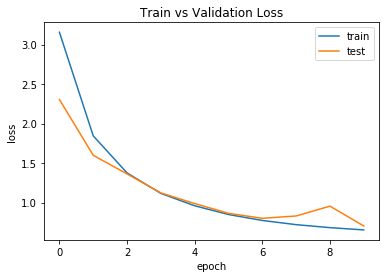

In [13]:
train_X_FINGER, train_y_FINGER = load_data("..//MURA-v1.1", body_part="FINGER", dataset_type="train")
validation_X_FINGER, validation_y_FINGER = load_data("..//MURA-v1.1", body_part="FINGER", dataset_type="validation")

train_X_FINGER = train_X_FINGER.reshape(-1, 224, 224, 3) / 255.0
validation_X_FINGER = validation_X_FINGER.reshape(-1, 224, 224, 3) / 255.0

history_inception = inception_model.fit(train_X_FINGER, train_y_FINGER, epochs=10, batch_size=64, validation_data=(validation_X_FINGER, validation_y_FINGER))

plotingModel(history_inception)

## Class: Elbow

Train on 4931 samples, validate on 465 samples
Epoch 1/10
4931/4931 [==============================] - 263s 53ms/sample - loss: 0.7457 - accuracy: 0.6577 - val_loss: 0.6735 - val_accuracy: 0.7376
Epoch 2/10
4931/4931 [==============================] - 204s 41ms/sample - loss: 0.6791 - accuracy: 0.7122 - val_loss: 0.6250 - val_accuracy: 0.7505
Epoch 3/10
4931/4931 [==============================] - 198s 40ms/sample - loss: 0.6412 - accuracy: 0.7272 - val_loss: 0.6062 - val_accuracy: 0.7462
Epoch 4/10
4931/4931 [==============================] - 198s 40ms/sample - loss: 0.6166 - accuracy: 0.7526 - val_loss: 0.6035 - val_accuracy: 0.7398
Epoch 5/10
4931/4931 [==============================] - 200s 41ms/sample - loss: 0.6132 - accuracy: 0.7443 - val_loss: 0.5826 - val_accuracy: 0.7591
Epoch 6/10
4931/4931 [==============================] - 199s 40ms/sample - loss: 0.6045 - accuracy: 0.7414 - val_loss: 0.5787 - val_accuracy: 0.7548
Epoch 7/10
4931/4931 [==============================] - 198

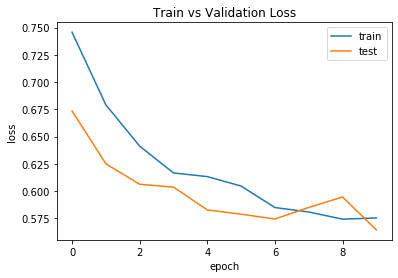

In [14]:
train_X_ELBOW, train_y_ELBOW = load_data("..//MURA-v1.1", body_part="ELBOW", dataset_type="train")
validation_X_ELBOW, validation_y_ELBOW = load_data("..//MURA-v1.1", body_part="ELBOW", dataset_type="validation")

train_X_ELBOW = train_X_ELBOW.reshape(-1, 224, 224, 3) / 255.0
validation_X_ELBOW = validation_X_ELBOW.reshape(-1, 224, 224, 3) / 255.0

history_inception = inception_model.fit(train_X_ELBOW, train_y_ELBOW, epochs=10, batch_size=64, validation_data=(validation_X_ELBOW, validation_y_ELBOW))

plotingModel(history_inception)

## Class: Forearm

Train on 1825 samples, validate on 301 samples
Epoch 1/10
1825/1825 [==============================] - 105s 57ms/sample - loss: 0.6476 - accuracy: 0.6904 - val_loss: 0.7036 - val_accuracy: 0.6213
Epoch 2/10
1825/1825 [==============================] - 80s 44ms/sample - loss: 0.5743 - accuracy: 0.7490 - val_loss: 0.6079 - val_accuracy: 0.7276
Epoch 3/10
1825/1825 [==============================] - 80s 44ms/sample - loss: 0.5488 - accuracy: 0.7781 - val_loss: 0.5947 - val_accuracy: 0.7475
Epoch 4/10
1825/1825 [==============================] - 80s 44ms/sample - loss: 0.5411 - accuracy: 0.7775 - val_loss: 0.6361 - val_accuracy: 0.6844
Epoch 5/10
1825/1825 [==============================] - 78s 43ms/sample - loss: 0.5246 - accuracy: 0.7940 - val_loss: 0.5964 - val_accuracy: 0.7243
Epoch 6/10
1825/1825 [==============================] - 78s 43ms/sample - loss: 0.5076 - accuracy: 0.8022 - val_loss: 0.6186 - val_accuracy: 0.7076
Epoch 7/10
1825/1825 [==============================] - 79s 43ms

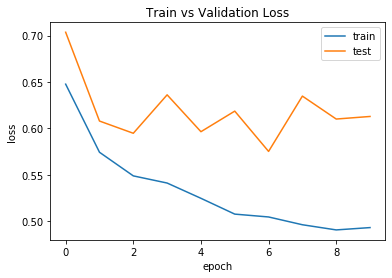

In [15]:
train_X_FOREARM, train_y_FOREARM = load_data("..//MURA-v1.1", body_part="FOREARM", dataset_type="train")
validation_X_FOREARM, validation_y_FOREARM = load_data("..//MURA-v1.1", body_part="FOREARM", dataset_type="validation")

train_X_FOREARM = train_X_FOREARM.reshape(-1, 224, 224, 3) / 255.0
validation_X_FOREARM = validation_X_FOREARM.reshape(-1, 224, 224, 3) / 255.0

history_inception = inception_model.fit(train_X_FOREARM, train_y_FOREARM, epochs=10, batch_size=64, validation_data=(validation_X_FOREARM, validation_y_FOREARM))

plotingModel(history_inception)

## Class: Hand

Train on 5543 samples, validate on 460 samples
Epoch 1/10
5543/5543 [==============================] - 426s 77ms/sample - loss: 0.6082 - accuracy: 0.7364 - val_loss: 0.6850 - val_accuracy: 0.6022
Epoch 2/10
5543/5543 [==============================] - 220s 40ms/sample - loss: 0.5860 - accuracy: 0.7491 - val_loss: 0.6512 - val_accuracy: 0.6283
Epoch 3/10
5543/5543 [==============================] - 222s 40ms/sample - loss: 0.5735 - accuracy: 0.7500 - val_loss: 0.6607 - val_accuracy: 0.6217
Epoch 4/10
5543/5543 [==============================] - 221s 40ms/sample - loss: 0.5644 - accuracy: 0.7510 - val_loss: 0.6444 - val_accuracy: 0.6326
Epoch 5/10
5543/5543 [==============================] - 222s 40ms/sample - loss: 0.5605 - accuracy: 0.7574 - val_loss: 0.6294 - val_accuracy: 0.6391
Epoch 6/10
5543/5543 [==============================] - 219s 39ms/sample - loss: 0.5583 - accuracy: 0.7568 - val_loss: 0.6172 - val_accuracy: 0.6565
Epoch 7/10
5543/5543 [==============================] - 218

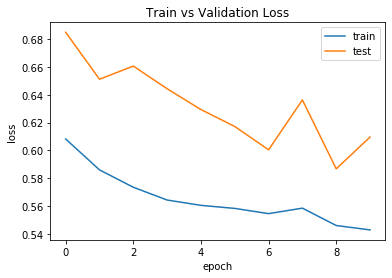

In [16]:
train_X_HAND, train_y_HAND = load_data("..//MURA-v1.1", body_part="HAND", dataset_type="train")
validation_X_HAND, validation_y_HAND = load_data("..//MURA-v1.1", body_part="HAND", dataset_type="validation")

train_X_HAND = train_X_HAND.reshape(-1, 224, 224, 3) / 255.0
validation_X_HAND = validation_X_HAND.reshape(-1, 224, 224, 3) / 255.0

history_inception = inception_model.fit(train_X_HAND, train_y_HAND, epochs=10, batch_size=64, validation_data=(validation_X_HAND, validation_y_HAND))

plotingModel(history_inception)

## Class: Shoulder

Train on 8379 samples, validate on 563 samples
Epoch 1/10
8379/8379 [==============================] - 512s 61ms/sample - loss: 0.6695 - accuracy: 0.6263 - val_loss: 0.6105 - val_accuracy: 0.7123
Epoch 2/10
8379/8379 [==============================] - 372s 44ms/sample - loss: 0.6263 - accuracy: 0.6818 - val_loss: 0.6102 - val_accuracy: 0.6945
Epoch 3/10
8379/8379 [==============================] - 527s 63ms/sample - loss: 0.6124 - accuracy: 0.6973 - val_loss: 0.5830 - val_accuracy: 0.7389
Epoch 4/10
8379/8379 [==============================] - 388s 46ms/sample - loss: 0.6046 - accuracy: 0.7045 - val_loss: 0.5847 - val_accuracy: 0.7300
Epoch 5/10
8379/8379 [==============================] - 365s 44ms/sample - loss: 0.6037 - accuracy: 0.7063 - val_loss: 0.5890 - val_accuracy: 0.7158
Epoch 6/10
8379/8379 [==============================] - 369s 44ms/sample - loss: 0.5973 - accuracy: 0.7156 - val_loss: 0.5743 - val_accuracy: 0.7460
Epoch 7/10
8379/8379 [==============================] - 397

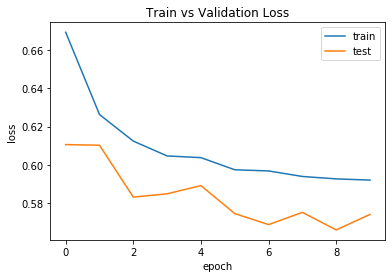

In [17]:
train_X_SHOULDER, train_y_SHOULDER = load_data("..//MURA-v1.1", body_part="SHOULDER", dataset_type="train")
validation_X_SHOULDER, validation_y_SHOULDER = load_data("..//MURA-v1.1", body_part="SHOULDER", dataset_type="validation")

train_X_SHOULDER = train_X_SHOULDER.reshape(-1, 224, 224, 3) / 255.0
validation_X_SHOULDER = validation_X_SHOULDER.reshape(-1, 224, 224, 3) / 255.0

history_inception = inception_model.fit(train_X_SHOULDER, train_y_SHOULDER, epochs=10, batch_size=64, validation_data=(validation_X_SHOULDER, validation_y_SHOULDER))

plotingModel(history_inception)

## Class: Humerus

Train on 1272 samples, validate on 288 samples
Epoch 1/10
1272/1272 [==============================] - 66s 52ms/sample - loss: 0.6719 - accuracy: 0.6462 - val_loss: 0.6003 - val_accuracy: 0.7257
Epoch 2/10
1272/1272 [==============================] - 58s 46ms/sample - loss: 0.6189 - accuracy: 0.6879 - val_loss: 0.5534 - val_accuracy: 0.7743
Epoch 3/10
1272/1272 [==============================] - 57s 45ms/sample - loss: 0.5945 - accuracy: 0.7146 - val_loss: 0.5222 - val_accuracy: 0.7882
Epoch 4/10
1272/1272 [==============================] - 73s 57ms/sample - loss: 0.5779 - accuracy: 0.7146 - val_loss: 0.5086 - val_accuracy: 0.7812
Epoch 5/10
1272/1272 [==============================] - 57s 45ms/sample - loss: 0.5643 - accuracy: 0.7508 - val_loss: 0.4974 - val_accuracy: 0.8090
Epoch 6/10
1272/1272 [==============================] - 59s 46ms/sample - loss: 0.5603 - accuracy: 0.7476 - val_loss: 0.4884 - val_accuracy: 0.8194
Epoch 7/10
1272/1272 [==============================] - 57s 45ms/

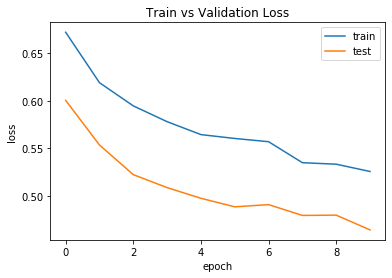

In [18]:
train_X_HUMERUS, train_y_HUMERUS = load_data("..//MURA-v1.1", body_part="HUMERUS", dataset_type="train")
validation_X_HUMERUS, validation_y_HUMERUS = load_data("..//MURA-v1.1", body_part="HUMERUS", dataset_type="validation")

train_X_HUMERUS = train_X_HUMERUS.reshape(-1, 224, 224, 3) / 255.0
validation_X_HUMERUS = validation_X_HUMERUS.reshape(-1, 224, 224, 3) / 255.0

history_inception = inception_model.fit(train_X_HUMERUS, train_y_HUMERUS, epochs=10, batch_size=64, validation_data=(validation_X_HUMERUS, validation_y_HUMERUS))

plotingModel(history_inception)

## Class: Wrist

In [19]:
train_X_WRIST, train_y_WRIST = load_data("..//MURA-v1.1", body_part="WRIST", dataset_type="train")
validation_X_WRIST, validation_y_WRIST = load_data("..//MURA-v1.1", body_part="WRIST", dataset_type="validation")

train_X_WRIST = train_X_WRIST.reshape(-1, 224, 224, 3) / 255.0
validation_X_WRIST = validation_X_WRIST.reshape(-1, 224, 224, 3) / 255.0

history_inception = inception_model.fit(train_X_WRIST, train_y_WRIST, epochs=10, batch_size=64, validation_data=(validation_X_WRIST, validation_y_WRIST))

plotingModel(history_inception)

MemoryError: Unable to allocate array with shape (9752, 1, 224, 224, 3) and data type float32